# COVID-19 Notebook- Tracking The Virus 

## By David R McKenna

Because the COVID crisis is affecting the entire world and I want to be aware of what is happening without having to rely on the data being filtered through a political lens, I created this notebook. I hope you enjoy it and feel free to modify the code at the bottom to investigate your own states of interest. 

### Import the necessary libraries, packages and functions to be used.

In [1]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import requests, json
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from sklearn.linear_model import LinearRegression
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

## Import the latest data 
 
### The data is imported from the covidtracking.com website. 

I create columns in the data frame for the Deaths per Case (DperP) and the Positive per Test as a percentage (PosPerTest). These will be used latter. I set the index to be the date as a datetime object. I then drop all the columns that are not used to speed things up a bit.

In [2]:
url = 'https://covidtracking.com/api/v1/states/daily.json'

r = requests.get(url)

json_data = r.json()

df = pd.json_normalize(json_data)

### Add calculate various relations of the data and add them as columns

df['DperP'] = df['death']/df['positive']  # Add columns Deaths per Positive case (DperP), Positive per Test (PosPerTest),  

df['PosPerTest']= df['positiveIncrease']/df['totalTestResultsIncrease']*100  # Positives per test in percentage

df['date'] = pd.to_datetime(df['date'], format = '%Y%m%d') #convert date to datetime object and set as index
df.set_index('date')

# Drop all unused columns. 

drop = ['pending',
        'hospitalizedCurrently', 'hospitalizedCumulative', 'onVentilatorCurrently',
        'onVentilatorCumulative','recovered', 'dataQualityGrade', 'lastUpdateEt',
        'dateModified','checkTimeEt', 'dateChecked','totalTestsViral', 'positiveTestsViral',
        'negativeTestsViral','positiveCasesViral', 'fips','posNeg','hash', 'commercialScore',
        'negativeRegularScore', 'negativeScore', 'positiveScore', 'score','grade']

df.drop(columns=drop, inplace=True)

#create date_ordinal column because it is sometimes earsier to refer to dates as ordinals
df['date_ordinal'] = pd.to_datetime(df['date']).apply(lambda date: date.toordinal())
#print('done')

## Subset and clean data:
I selected UT first because that is where I live. There were some clear outliers so I replaced them with the average over the two days. It appears that there was a correction for an overcount or overreported value so I took the sum and divided by two = 12. This may not be the exact values for each day but preserves the integrity of the average over the corrected dates. 

In [3]:
UT = df[df['state']=='UT']
UT= UT[UT['date'] >= '2020-03-15' ]

A = UT['hospitalizedIncrease'].loc[lambda x: x==389].index
B = UT['hospitalizedIncrease'].loc[lambda x: x== -365].index
C = UT['positiveIncrease'].loc[lambda x: x== 0].index

UT.loc[A,'hospitalizedIncrease'] = 12
UT.loc[B,'hospitalizedIncrease'] = 12
UT.drop(C,inplace=True)


## Setup global characteristics for plots. 
Plots will have the basic seaborn appearance and will have a watermark with attributions. date_ticks overcomes the issues of plotting datetime indexed datasets, especially if there is analysis, fitting, or averaging, this also allows quick scaling of the date interval presented. This is useful as the duration of the virus increases rescaling the interval provides a fast and easy way to keep the plots readable.



In [4]:
sns.set()  

# create a watermark for the plots that declares my ownership and 
# attributes where I got the data
def watermark(loc_x = 0.92, loc_y =0.15):
    """ Puts Property Of David McKenna on LRH corner of plots"""
    
    fig.text(loc_x,loc_y, 'Property of David McKenna \n data from: covidtracking.com',
         fontsize=10, color='gray', rotation=270,
         ha='right', va='bottom', alpha=0.75)

    # Format the datetime x-axis tick marks    
def date_ticks(interval = 7) :
    # Define the date format
    date_form = DateFormatter("%m-%d")
    ax.xaxis.set_major_formatter(date_form)

    # Ensure a major tick for each week using (interval=_) 
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=interval))
    plt.xticks(rotation=30)

# Calculate the rolling averages of selected columns     
def Roll_Avg(df, col, interval) :
    """Calculate the rolling averages of interval duration of columns in df"""
    length = len(interval)
    
    for n in range(length) :
        # make new col called roll_col_interval
        new_col = 'roll_' + str(col) + '_'+ str(interval[n])
        
        df[new_col] = df.loc[:,col].rolling(interval[n]).mean().shift(periods= - interval[n])
        
def place_value(number): 
    return ("{:,}".format(number))

def annot_tot(df,col,value) :
    today = df.date.max()
    total = df[col].sum()
    x_loc = df.date.min() + pd.DateOffset(5)
    y_loc = df[col].max()/ 1.75
    value_today =df[col].iloc[0]
    plt.annotate('Today: {}'.format(place_value(value_today)),(today + pd.DateOffset(2),value_today/1.75),
                 rotation=270,color='darkslateblue',fontsize=14)
    plt.annotate('Total '+ value +': {}'.format(place_value(total)),(x_loc,y_loc), fontsize = 16,color='navy')

## Define the dates where UT changes their COVID status' from Red to Orange and Orange to Yellow.
I added Memorial Day and the start of Protests as well as 7-days after each (hashed-line), to visualize possible effects these events might have on case increases. my_annotate allows for flexible location and removal of text labels.



In [5]:
# Define the dates of transitions by their ordinal date
OrangeDate = UT[UT['date']=='2020-04-28']['date_ordinal']
OrangeDate = int(OrangeDate)

YellowDate = UT[UT['date']=='2020-05-14']['date_ordinal']
YellowDate = int(YellowDate)

MemorialDay = UT[UT['date']=='2020-05-25']['date_ordinal']
MemorialDay = int(MemorialDay)

ProtestDate = UT[UT['date']=='2020-05-29']['date_ordinal']
ProtestDate = int(ProtestDate)

DataSupression = UT[UT['date']=='2020-07-15']['date_ordinal']
DataSupression = int(DataSupression)
#Define a function that adds the vertical lines at the relevent dates
def my_annotate(text_loc,sup_loc, text=True) :
    """Setup the anotations of the plots- marking of significant dates"""
    
    ax.axvline(x=OrangeDate, color='tab:orange', linewidth=2,alpha=0.5)
    ax.axvline( x=YellowDate, color='gold', linewidth=2,alpha=0.5)
    ax.axvline( x=MemorialDay, color='tab:red', linewidth=1.5,alpha=0.5)
    ax.axvline( x=ProtestDate, color='tab:purple', linewidth=1.5,alpha=0.5)
    ax.axvline(x=OrangeDate + 7, color='tab:orange', linewidth=2, linestyle = '--',alpha=0.5)
    ax.axvline( x=YellowDate + 7, color='gold', linewidth=2, linestyle = '--',alpha=0.5)
    ax.axvline( x=ProtestDate + 7, color='tab:purple', linewidth=2, linestyle = '--',alpha=0.5)
    ax.axvline( x=DataSupression, color='red', linewidth=4, linestyle = '-',alpha=0.5)    
    if text==True:
        ax.annotate('Code Orange Date', (OrangeDate - 2,text_loc),color='black',rotation=90,fontsize=13,alpha=0.5)
        ax.annotate('Code Yellow Date', (YellowDate - 2,text_loc),color='black',rotation=90,fontsize=13,alpha=0.5)
        ax.annotate('Memorial Day', (MemorialDay - 2 ,text_loc),color='black',rotation=90,fontsize=13,alpha=0.5)
        ax.annotate('Protest Start Date', (ProtestDate - 2 ,text_loc),color='black',rotation=90,fontsize=13,alpha=0.5)
        ax.annotate('Code Orange + 7-Days', (OrangeDate + 5,text_loc),color='black',rotation=90,fontsize=13,alpha=0.5)
        ax.annotate('Data To HHS', (DataSupression - 22,sup_loc),color='red',fontsize=13,alpha=0.75)

## The US total Case and Deaths per day:
For a quick look at what is happening nationwide.

Today is Aug-13-2020 


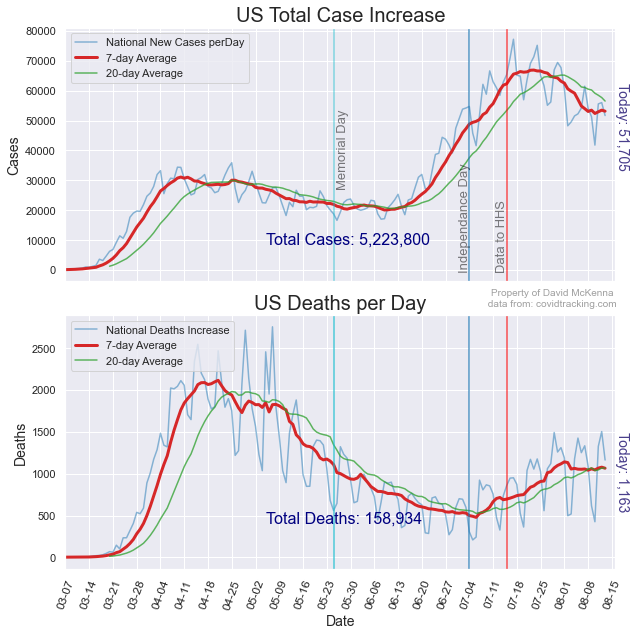

In [6]:
# Plot the national case increase with 20-day average
sns.set()
# clean up bad data point, I found the actual number from NJ.gov website (was 1877)
df.loc[(df['date']=='2020-06-25') & (df['state']=='NJ'),'deathIncrease']=23
df = df[df['date'] >= '2020-03-01']
today = max(df['date'])
print('Today is ' + today.strftime("%b-%d-%Y "))
total_case = df['positiveIncrease'].sum()
total_death = df['deathIncrease'].sum()
x_loc = df.date.max() - pd.DateOffset(100)
y_loc_c = df['positiveIncrease'].max()/ 1.75
y_loc_d = df['deathIncrease'].max()/ 2.3
interval = 7


value_today_case = df.groupby('date')['positiveIncrease'].sum().iloc[-1]
value_today_death = df.groupby('date')['deathIncrease'].sum().iloc[-1]

start = df[df['date']=='2020-03-07']['date'].iloc[0]
end = df.date.max() + dt.timedelta(days=3) 

fig, ax = plt.subplots(2,1,sharex=True,figsize = (9,9))

fig.text(0.96,0.515, 'Property of David McKenna \n data from: covidtracking.com',
         fontsize=10, color='gray',
         ha='right', va='bottom', alpha=0.75)
df.groupby('date')['positiveIncrease'].sum().plot(ax=ax[0],label='National New Cases perDay',
                                                        color='tab:blue',alpha=0.5)
df.groupby('date')['positiveIncrease'].sum().rolling(7).mean().plot(ax=ax[0],label='7-day Average',
                                                                    color='tab:red',linewidth=3)
df.groupby('date')['positiveIncrease'].sum().rolling(20).mean().plot(ax=ax[0],label='20-day Average',
                                                                    color='tab:green',alpha=0.75)

ax[0].axvline(x='2020-05-25',
              color='tab:cyan', linewidth=1.5, alpha=0.5)
ax[0].annotate('Memorial Day', ('2020-05-26'  ,28000),
               color='black',rotation=90,fontsize=13,alpha=0.5)
ax[0].axvline(x='2020-07-04',
              color='tab:blue', linewidth=1.5, alpha=0.75)
ax[0].annotate('Independance Day', ('2020-07-01'  ,0),
               color='black',rotation=90,fontsize=13,alpha=0.5)
ax[0].axvline(x='2020-07-15',
              color='red', linewidth=2, alpha=0.5)
ax[0].annotate('Data to HHS', ('2020-07-12'  ,0),
               color='black',rotation=90,fontsize=13,alpha=0.5)

date_form = DateFormatter("%m-%d")
               
ax[0].xaxis.set_major_formatter(date_form)
ax[0].annotate('Total Cases: {}'.format(place_value(total_case)),(x_loc,y_loc_c), fontsize = 16,color='navy')
# Ensure a major tick for each week using (interval=_) 
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=interval))
ax[0].legend(loc='upper left')
ax[0].set_title('US Total Case Increase', fontdict={'fontsize':20}) 
ax[0].annotate('Today: {}'.format(place_value(value_today_case)),
               (end ,value_today_case/1.5),
                 rotation=270,color='darkslateblue',fontsize=14)
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=30)
ax[0].set_ylabel('Cases', fontdict={'fontsize':14})
#ax[0].set_xlim([start,end])
df.groupby('date')['deathIncrease'].sum().plot(ax=ax[1],label='National Deaths Increase',color='tab:blue',alpha=.5)
df.groupby('date')['deathIncrease'].sum().rolling(7).mean().plot(ax=ax[1],label='7-day Average',
                                                                color='tab:red',linewidth=3)
df.groupby('date')['deathIncrease'].sum().rolling(20).mean().plot(ax=ax[1],label='20-day Average',
                                                                  color='tab:green',alpha=0.75)

ax[1].xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=_) 
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=interval))
ax[1].annotate('Today: {}'.format(place_value(value_today_death)),
               (end ,value_today_death/2),
                 rotation=270,color='darkslateblue',fontsize=14)
ax[1].axvline(x='2020-05-25', color='tab:cyan', linewidth=1.5, alpha=0.75)
ax[1].axvline(x='2020-07-04', color='tab:blue', linewidth=1.5, alpha=0.75)
ax[1].axvline(x='2020-07-15',
              color='red', linewidth=2, alpha=0.5)
ax[1].annotate('Total Deaths: {}'.format(place_value(total_death)),(x_loc,y_loc_d), fontsize = 16,color='navy')
ax[1].legend(loc='upper left')

ax[1].set_title('US Deaths per Day', fontdict={'fontsize':20}) 
plt.setp(ax[1].xaxis.get_majorticklabels(), rotation=70,fontsize=12 )
ax[1].set_ylabel('Deaths', fontdict={'fontsize':14})
ax[1].set_xlabel('Date', fontdict={'fontsize':14})
ax[1].set_xlim([start,end])

fig = plt.tight_layout()
plt.savefig('national.png')
plt.show()



## Plot the Daily Case Increase with 7 & 20 day rolling average
I chose to do a rolling average at 7 & 20 days to smooth out the natural oscillations in the data that may caused by diﬀiculties of reporting during the weekend and subsequently over reporting during the following couple days. The oscillations are on the order of 3 days so the 7 day average is suﬀicient to smooth them out as well as be sensitive enough to react quickly to sudden spikes. The 20 day average gives a more general shape of the curve.

In [7]:
states_won = {
        'AK': 'Trump',
        'AL': 'Trump',
        'AR': 'Trump',
        'AZ': 'Trump',
        'CA': 'Clinton',
        'CO': 'Clinton',
        'CT': 'Clinton',
        'DC': 'Clinton',
        'DE': 'Clinton',
        'FL': 'Trump',
        'GA': 'Trump',
        'HI': 'Clinton',
        'IA': 'Trump',
        'ID': 'Trump',
        'IL': 'Clinton',
        'IN': 'Trump',
        'KS': 'Trump',
        'KY': 'Trump',
        'LA': 'Trump',
        'MA': 'Clinton',
        'MD': 'Clinton',
        'ME': 'Clinton',
        'MI': 'Trump',
        'MN': 'Clinton',
        'MO': 'Trump',
        'MS': 'Trump',
        'MT': 'Trump',
        'NC': 'Trump',
        'ND': 'Trump',
        'NE': 'Trump',
        'NH': 'Clinton',
        'NJ': 'Clinton',
        'NM': 'Clinton',
        'NV': 'Clinton',
        'NY': 'Clinton',
        'OH': 'Trump',
        'OK': 'Trump',
        'OR': 'Clinton',
        'PA': 'Trump',
        'RI': 'Clinton',
        'SC': 'Trump',
        'SD': 'Trump',
        'TN': 'Trump',
        'TX': 'Trump',
        'UT': 'Trump',
        'VA': 'Clinton',
        'VT': 'Clinton',
        'WA': 'Clinton',
        'WI': 'Trump',
        'WV': 'Trump',
        'WY': 'Trump'
}
df_2016 = df
df_2016['2016 Won By'] = df_2016['state'].map(states_won)
df_2016 = df_2016[df_2016['2016 Won By'].notna()]
df_2016['2016 Won By'] = df_2016['2016 Won By'].apply(lambda x: 'States Won By '+str(x))

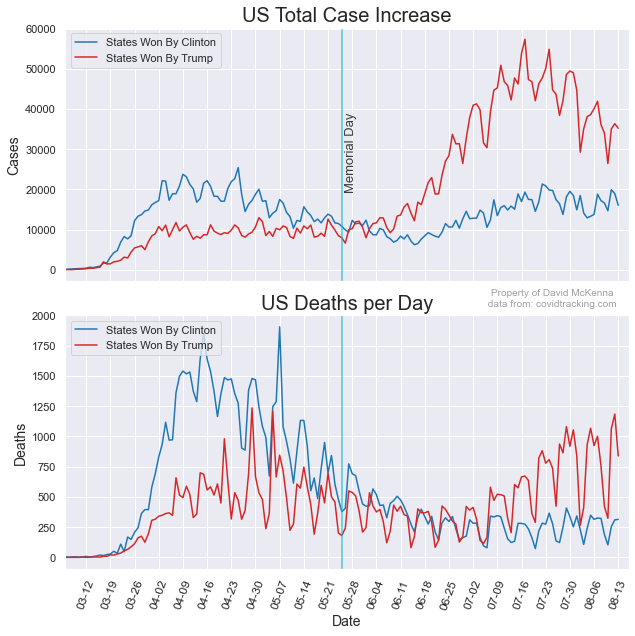

In [8]:

interval = 7
fig, ax = plt.subplots(2,1,sharex=True,figsize = (9,9))
end = df_2016.date.max() + pd.DateOffset(3)
fig.text(0.96,0.515, 'Property of David McKenna \n data from: covidtracking.com',
         fontsize=10, color='gray',
         ha='right', va='bottom', alpha=0.75)
df_2016.groupby(['date','2016 Won By'])['positiveIncrease'].sum().unstack().plot(ax=ax[0],label=['Clinton','Trump'],
                                                        color=['tab:blue','tab:red'])
ax[0].axvline(x='2020-05-25',
              color='tab:cyan', linewidth=1.5, alpha=0.75)
ax[0].annotate('Memorial Day', ('2020-05-26'  ,20000),
               color='black',rotation=90,fontsize=13,alpha=0.75)
date_form = DateFormatter("%m-%d")
ax[0].xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=_) 
ax[0].xaxis.set_major_locator(mdates.DayLocator(interval=interval))
ax[0].legend(loc='upper left')
ax[0].set_title('US Total Case Increase', fontdict={'fontsize':20}) 
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=30)
ax[0].set_ylabel('Cases', fontdict={'fontsize':14})
today = max(df_2016['date'])

df_2016.groupby(['date','2016 Won By'])['deathIncrease'].sum().unstack().plot(ax=ax[1],
                                                    color=['tab:blue','tab:red'])

ax[1].xaxis.set_major_formatter(date_form)

# Ensure a major tick for each week using (interval=_) 
ax[1].xaxis.set_major_locator(mdates.DayLocator(interval=interval))

ax[1].axvline(x='2020-05-25', color='tab:cyan', linewidth=1.5, alpha=0.75)

ax[1].legend(loc='upper left')
ax[0].set_xlim('2020-03-06',end)
ax[1].set_title('US Deaths per Day', fontdict={'fontsize':20}) 
plt.setp( ax[1].xaxis.get_majorticklabels(), rotation=70,fontsize=12 )
ax[1].set_ylabel('Deaths', fontdict={'fontsize':14})
ax[1].set_xlabel('Date', fontdict={'fontsize':14})
fig = plt.tight_layout()
plt.savefig('Clinton_Trump_COVID.png')

plt.show()

## Plot the Daily Case Increase with 7 & 20 day rolling average
I chose to do a rolling average at 7 & 20 days to smooth out the natural oscillations in the data that may caused by difficulties of reporting during the weekend and subsequently over reporting during the following couple days. The oscillations are on the order of 3 days so the 7 day average is sufficient to smooth them out as well as be sensitive enough to react quickly to sudden spikes. The 20 day average gives a more general shape of the curve.


In [ ]:
# Calculate the 7 & 20 day rolling averages:
Roll_Avg(UT, 'positiveIncrease', [7,20])

#define location for the text labels on annotations
text_loc = max(UT['positiveIncrease'])/1.75
today = UT.date.max()
value_today = UT['positiveIncrease'].iloc[0]
print('today is: {}'.format(today.strftime("%b-%d-%Y")))
# Create barplot of the case increase with rolling averages overlayed.
fig, ax = plt.subplots(figsize = (12,6))
watermark() #add watermark with attributions
my_annotate(text_loc,sup_loc= UT.positiveIncrease.max()+10) #add annotated lines to mark relevent dates
plt.bar(UT['date'], UT['positiveIncrease'], label='Positive Increase',color='grey')
plt.plot(UT['date'], UT.roll_positiveIncrease_7,
         label='7 Day Average', color='green')
plt.plot(UT['date'], UT.roll_positiveIncrease_20,
         label='20 Day Average', color='blue')
date_ticks() #format the dates on x-axis
annot_tot(UT,'positiveIncrease','Case')
plt.legend(loc='upper left')
plt.title('Utah Case Increase Rolling Average', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Case Increase', fontdict={'fontsize':12})


plt.savefig('Utah_Increase_Rolling_Avg.png')
plt.show()


today is: Aug-13-2020


Locator attempting to generate 113030 ticks ([-17622.0, ..., 773581.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 113030 ticks ([-17622.0, ..., 773581.0]), which exceeds Locator.MAXTICKS (1000).


KeyboardInterrupt: 

Locator attempting to generate 113030 ticks ([-17622.0, ..., 773581.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 113030 ticks ([-17622.0, ..., 773581.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 113030 ticks ([-17622.0, ..., 773581.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 113030 ticks ([-17622.0, ..., 773581.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 113030 ticks ([-17622.0, ..., 773581.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 113030 ticks ([-17622.0, ..., 773581.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 113030 ticks ([-17622.0, ..., 773581.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 113030 ticks ([-17622.0, ..., 773581.0]), which exceeds Locator.MAXTICKS (1000).
Locator attempting to generate 113030 ticks ([-17622.0, ..., 773581.0]), which exceeds Locator.MAXTICKS 

## Plot the Daily Incresase in cases as well as hospitalizations
The daily increase in cases doesn't tell the whole story. The true danger of the pandemic is when the number of hospitalizations exceeds the capacity of the local healthcare system. I add to the case increase plot the fraction of those that are hospitalized. Because hospitalization often occurs after diagnosis, the daily hospitalizations may lag the case increase.


In [ ]:
#Create overlapping bar plots of case increase and hospitalizations
fig, ax = plt.subplots(figsize = (12,6))
watermark() #add atribution watermark

ax.bar(UT['date'], UT['positiveIncrease'], label='Case Increase',color='tab:blue')
ax.bar(UT['date'], UT['hospitalizedIncrease'], 
       label='Hospitalized Increase',color='tab:red')

ax.legend(loc='upper left')
my_annotate(text_loc,sup_loc= UT.positiveIncrease.max()+10) # add annotated lines of relevent dates

date_ticks() #format the dates on x-axis 

plt.title('Utah Case Increase (non)Hospitalized', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Case Increase', fontdict={'fontsize':12})
plt.axis('tight')

#plt.savefig('Utah_Increase_Hospitalized.png')
plt.show()

## Plot the Daily Deaths with 7 & 20 day rolling average
Ultimately, the metric of interest is the number of deaths. As long as hospitalizations don't overwhelm the system the number of deaths should stay relatively low. If we see a sudden and sustained increase in deaths it may indicate the overwhelming of the hospitals.


In [ ]:
# Calculate the 7 & 20 day rolling averages:
Roll_Avg(UT,'deathIncrease', [7,20])

fig, ax = plt.subplots(figsize = (12,6))
watermark()
my_annotate(text_loc,sup_loc= UT.positiveIncrease.max()+10,text=False)
plt.bar(UT['date'], UT['deathIncrease'], label='Death Increase',color='grey')
plt.plot(UT['date'], UT.roll_deathIncrease_7, label='7 Day Average', color='green')
plt.plot(UT['date'], UT.roll_deathIncrease_20, label='20 Day Average', color='blue')
plt.legend(loc='upper left')
annot_tot(UT,'deathIncrease','Deaths')
date_ticks()

plt.title('Utah Deaths Increase Rolling Average', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Deaths Increase', fontdict={'fontsize':12})
plt.axis('tight')

#plt.savefig('Utah_Death_Rolling_Avg.png')
plt.show()

## Plot the Total tests and which of those are positive
I now turn my attention to the testing in Utah. Here I plot the daily test increase and the fraction of those that return positive. Again, the positive test may lag the total because it takes up to 48 hrs to receive results.


In [ ]:
sns.set()

fig, ax = plt.subplots(figsize = (12,6))
watermark(loc_x=0.93)
my_annotate(text_loc,sup_loc= UT.positiveIncrease.max()+10,text=False) #add annotation lines without text

ax.bar(UT['date'], UT['totalTestResultsIncrease'],
       label='Total Test Increase',color='tab:green',alpha=0.75)
ax.bar(UT['date'], UT['positiveIncrease'],
       label='Positive Tests',color='tab:red',alpha=0.75)
date_ticks()

ax.legend(loc='upper left')
plt.title('Utah Total Tests Per Day', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Tests', fontdict={'fontsize':12})
plt.axis('tight')
annot_tot(UT,'totalTestResultsIncrease','Tests')
#plt.savefig('Utah_Increase_Test.png')

plt.show()

## For clarity I plot the positive test rate as a percentage of total tests
The positive test rate can help determine if we are testing enough. A low positive test rate could indicate that the tests represent a good sample of the population. A large positive rate could indicate 1) there are not enough tests being performed for screening, 2) there is a spike in the local outbreak, 3) the virus is extremely contagious. In this case we see it level off at about 5% for a while, this gives me confidence that at that time there were sufficient tests performed and the actual infection rate was about 5%. About 5-29 the rate starts increasing which might indicate a new spike in cases, or that we have dropped below the threshold of tests per day to provide an accurate picture.


In [ ]:
# calculate the 7 & 20 day rolling averages
Roll_Avg(UT,'PosPerTest', [7,20])
#define dates of interest in terms of ordinal
start = UT[UT['date'] == '2020-04-16']['date']
end = UT.date.max() + pd.DateOffset(1)

fig, ax = plt.subplots(figsize = (12,6))
watermark()

fig = sns.regplot(x = 'date', y = 'PosPerTest', data = UT, fit_reg=False)
plt.plot(UT['date'], UT.roll_PosPerTest_7, label='7 Day Average', color='green')
plt.plot(UT['date'], UT.roll_PosPerTest_20, label='20 Day Average', color='blue')

date_ticks()

plt.legend(loc='upper right')
ax.set_xlim(start,end)  
ax.set_ylim(0,30)
plt.title('UT Positve Per Test', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Positive/Test', fontdict={'fontsize':12})

#plt.savefig('UT_Positive_Per_Test.png')
plt.show()

## It is easier to see the Total Tests, Positive Tests, and the Positive per Test

From the linear fit it is clear to see that the Total Tests per day is decreasing while the Positive Tests per day is increasing, this yields a proportional increase in Positives per Test. This contradicts the claim of President of testing bias, ie. we have more cases just because we are testing more. This is the case only when not enough tests are being performed. It is also important to understand that tests IDENTIFY cases, they do NOT CREATE cases. If there are insufficient tests being done to create a representation of the population (sufficient randomized sample) then if testing is increased it will identify more cases until the sampling threshold is reached, once reached the case rate will level off at the 'true' value.

In [ ]:
Roll_Avg(UT,'totalTestResultsIncrease',[7])
Roll_Avg(UT,'positiveIncrease',[7])
UT_1 = UT[UT['date'] >= '2020-05-01'] # select the data after the rampup of testing
#define start and end dates for x limits- thus we can average
#over all data but only plot the interesing part
start = UT_1[UT_1['date'] == '2020-04-15']['date']
end = UT_1.date.max() + pd.DateOffset(1)
Roll_Avg(UT,'PosPerTest', [10])


sns.set_style("dark")  # to remove grid lines because of the 2 y axis they overlap and are confusing                  
fig, ax1 = plt.subplots(figsize = (12,6))

plt.title('UT Tests and Positive per Test', fontdict={'fontsize':20})
date_ticks()
watermark(loc_x=0.94)

color = 'gray'

ax1.bar(UT_1['date'], UT_1['totalTestResultsIncrease'], 
        label='Total Tests',color='gray',alpha=0.5)
ax1.bar(UT_1['date'], UT_1['positiveIncrease'], 
        label='Positive Tests',color='tab:red',alpha=0.6)
ax1.plot(UT_1['date'],UT_1.roll_totalTestResultsIncrease_7, color='black',
         linestyle = '--', linewidth = 3,
         label = 'Test Increase 7-day Avg')
ax1.plot(UT_1['date'],UT_1.roll_positiveIncrease_7, color='firebrick',
         linestyle = '--', linewidth = 3,
         label = 'New Cases 7-day Avg')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
fig = plt.ylabel('Tests', fontdict={'fontsize':12},color=color)

ax2 = ax1.twinx() 

color = 'green'
fig = plt.scatter(UT_1['date'], UT_1['PosPerTest'],
                  marker='+',s=100,color='tab:green' ,label='Percent Positive Tests')
ax2 = plt.plot(UT_1['date'], UT_1.roll_PosPerTest_7, label='10 Day Average (Rate of Infection)', color='tab:green')
ax2 = plt.ylabel('Positive/Test', fontdict={'fontsize':12},color=color)
ax2 = plt.tick_params(axis='y', labelcolor=color)
ax2 = plt.ylim(0,25)
ax2 = plt.legend(loc='upper right')

fig = plt.tight_layout()

plt.savefig('UT_Test_+_Positive_Per_Test.png')
plt.show()


## We can look closer at the Hospital situation
Here I plot the hospitalizations by day and the fraction of those that are admitted to the ICU. Again, the ICU data may lag the hospitalizations as patients are usually admitted to the hospital and then admitted to the ICU at a later date if their symptoms worse. Since space in the ICU is limited, when they become full is where we should best define the capacity of the healthcare system. Deaths that otherwise may have been prevented will occur when ICU is over capacity and triage would need to begin.


In [ ]:
# again using the truncated set because ICU data wasn't available before 5-8
UT.sort_index() #sort by date

#create shifted column that I can then calculate the daily increase
UT['PreviousDayICU'] = UT['inIcuCumulative'].shift(-1)

# iterate through the rows to calculate daily increase in ICU cases
for row in UT.iterrows() :
    UT['icuIncrease'] = UT['inIcuCumulative'] - UT['PreviousDayICU']

#drop the added column from data frame
UT.drop(columns = 'PreviousDayICU',inplace=True)
UTH = UT[UT['date']>='2020-04-29' ]
#define x limits to frame the timeframe of interest
start = UTH[UTH['date'] == '2020-05-02']['date']
end = UTH.date.max() + pd.DateOffset(2)
sns.set()# reset the plot style
fig, ax = plt.subplots(figsize = (12,6))
watermark()
my_annotate(text_loc = 18,sup_loc= UT.hospitalizedIncrease.max()+10,text=False)
# annot_tot(UTH,'hospitalizedIncrease','Hospitalizations')
# annot_tot(UTH,'icuIncrease','In ICU')

ax.bar(UTH['date'], UTH['hospitalizedIncrease'],
       label='Total Hospital Increase',color='tab:blue',alpha=0.75)
ax.bar(UTH['date'], UTH['icuIncrease'],
       label='ICU Increase',color='tab:red',alpha=0.75)
ax.legend(loc='upper left')
ax.set_xlim(start,end)

#set max y-value to be the max in window of interest + 10
ax.set_ylim(0,max(UTH[UTH['date']>= '2020-05-02']['hospitalizedIncrease'])+10)
plt.title('Hospitalizations and ICU Increase', fontdict={'fontsize':20})
plt.ylabel('Hospitalized Cases', fontdict={'fontsize':12})
date_ticks()
#plt.savefig('ICU.png')
plt.show()

## I do a similar overlay of Hospitalizations and ICU as I did with Tests:

I add linear regression for the hospitalizations and the ICU case increase. I also plot the positive per test percentage with its 7-day average. This gives a good picture of the critical, decision making, trends. Ultimately, to make sure there are no otherwise preventable deaths we need to keep the ICU below capacity (more importantly below ventilator capacity) so as not to overwhelm the health care system. As the hospitalizations and ICU cases trend upward mitigation strategies should be put back in place.


In [ ]:
UT_1 = UT[UT['date'] >= '2020-04-20'] # select the data after the rampup of testing
#define start and end dates for x limits- thus we can average
#over all data but only plot the interesing part
start = UT_1[UT_1['date'] == '2020-05-11']['date']
end = UT_1.date.max() + pd.DateOffset(1)
UT_1 = UT_1[(UT_1['icuIncrease']<1000) & (UT_1['icuIncrease']>=0)]
Roll_Avg(UT_1,'PosPerTest', [7])
# I use the scikit LinearRegression to perfrom the least squares linear fit of the data

#setup the x values to be fit as ordinal because LinerRegressor doesnt like datetime objs
X_i = UT_1['date_ordinal']  
X_i = np.array(X_i).reshape(-1,1)
X_t = X_i
# Create the Y values for the two fits we will do
Y_i = UT_1['hospitalizedIncrease']
Y_t = UT_1['icuIncrease']

linear_regressor_i = LinearRegression()  # create object for the class
linear_regressor_i.fit(X_t, Y_i)  # perform linear regression
Y_i_pred = linear_regressor_i.predict(X_i)  # make predictions

linear_regressor_t = LinearRegression()  
linear_regressor_t.fit(X_t, Y_t)  
Y_t_pred = linear_regressor_t.predict(X_t) 

sns.set_style("dark")  # to remove grid lines because of the 2 y axis they overlap and are confusing                  
fig, ax1 = plt.subplots(figsize = (12,6))

plt.title('UT Hospitalization & ICU Increase', fontdict={'fontsize':20})
watermark(loc_x=0.94)
date_ticks()
color = 'tab:blue'

ax1.bar(UT_1['date'], UT_1['hospitalizedIncrease'], 
        label='Hospitalizations',color='tab:blue',alpha=0.5)
ax1.bar(UT_1['date'], UT_1['icuIncrease'], 
        label='ICU',color='tab:red',alpha=0.6)
ax1.plot(UT_1['date'],Y_i_pred, color='mediumblue',
         linestyle = '--', linewidth = 3, 
         label = 'Hospitalization Slope: {:.2f}'.format(linear_regressor_i.coef_[0]))
ax1.plot(UT_1['date'],Y_t_pred, color='firebrick',
         linestyle = '--', linewidth = 3,
         label = 'ICU Increase Slope: {:.2f}'.format(linear_regressor_t.coef_[0]))
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
fig = plt.ylabel('Case Increase', fontdict={'fontsize':12},color=color)

ax2 = ax1.twinx() 

color = 'indigo'
fig = plt.scatter(UT_1['date'], UT_1['PosPerTest'],
                  marker='^',s=100,color='indigo' ,label='Percent Positive Tests',alpha=0.75)
ax2 = plt.plot(UT_1['date'], UT_1.roll_PosPerTest_7, label='7 Day Average (Rate of Infection) ', color='indigo')
ax2 = plt.ylabel('Positive/Test', fontdict={'fontsize':12},color=color)
ax2 = plt.tick_params(axis='y', labelcolor=color)
ax2 = plt.ylim(0,25)
ax2 = plt.legend(loc='upper right')

fig = plt.tight_layout()

plt.savefig('UT_Hospital_+_Positive_Per_Test.png')
plt.show()


In [ ]:
Roll_Avg(UT,'hospitalizedIncrease',[20])
Roll_Avg(UT,'icuIncrease',[20])

UT_1 = UT[UT['date'] >= '2020-04-20'] # select the data after the rampup of testing
#define start and end dates for x limits- thus we can average
#over all data but only plot the interesing part
start = UT_1[UT_1['date'] == '2020-05-11']['date']
end = UT_1.date.max() + pd.DateOffset(1)
UT_1 = UT_1[(UT_1['icuIncrease']<1000) & (UT_1['icuIncrease']>=0)]
Roll_Avg(UT_1,'PosPerTest', [7])



sns.set_style("dark")  # to remove grid lines because of the 2 y axis they overlap and are confusing                  
fig, ax1 = plt.subplots(figsize = (12,6))

plt.title('UT Hospitalization & ICU Increase', fontdict={'fontsize':20})
watermark(loc_x=0.94)
date_ticks()
color = 'tab:blue'

ax1.bar(UT_1['date'], UT_1['hospitalizedIncrease'], 
        label='Hospitalizations',color='tab:blue',alpha=0.5)
ax1.bar(UT_1['date'], UT_1['icuIncrease'], 
        label='ICU',color='tab:red',alpha=0.6)
ax1.plot(UT_1['date'],UT_1.roll_hospitalizedIncrease_20, color='mediumblue',
         linestyle = '--', linewidth = 3,
        label= 'Hospitalization 20-Day Average')
ax1.plot(UT_1['date'],UT_1.roll_icuIncrease_20, color='firebrick',
         linestyle = '--', linewidth = 3,
         label = 'ICU 20-Day Average')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
fig = plt.ylabel('Case Increase', fontdict={'fontsize':12},color=color)

ax2 = ax1.twinx() 

color = 'indigo'
fig = plt.scatter(UT_1['date'], UT_1['PosPerTest'],
                  marker='^',s=100,color='indigo' ,label='Percent Positive Tests',alpha=0.75)
ax2 = plt.plot(UT_1['date'], UT_1.roll_PosPerTest_7, label='7 Day Average (Rate of Infection)', color='indigo')
ax2 = plt.ylabel('Positive/Test', fontdict={'fontsize':12},color=color)
ax2 = plt.tick_params(axis='y', labelcolor=color)
ax2 = plt.ylim(0,25)
ax2 = plt.legend(loc='upper right')

fig = plt.tight_layout()

plt.savefig('UT_Test_+_Positive_Per_Test_Rolling.png')
plt.show()

## Now I compare the Deaths and Deaths per case in UT with nearby states
I added in New York to the Deaths Per Case to compare. When compared the nearest states UT has one of the lowest total deaths and the lowest deaths per case. All investigated states have a level or negative slope in the deaths per case, this is good news. That means that although cases are increasing the chance of survival is also increasing. This is most likely due to better treatment plans, although it could suggest the most at risk people already got infected and were lost. I like to think it is because of better treatment. A sudden increase in deaths per case canm indicate a saturation of ICU capacity. 

In [ ]:
fc = df[df['state'].isin(['UT','AZ','CO','NM','ID','WY'])]
fc['Date'] = pd.to_datetime(df['date'].astype(str), infer_datetime_format=True)
fc['Date'] = fc[fc['date']>= '03-10-2020']
sns.set()
fig, ax = plt.subplots(figsize = (12,6)) 
watermark()
fig = fc.groupby(['date','state']).sum()['death'].unstack().plot(ax=ax)
date_form = DateFormatter("%m-%d")
ax.xaxis.set_major_formatter(date_form)
date_ticks()


plt.title('Nearest States: Total Deaths' , fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Deaths', fontdict={'fontsize':12})

plt.show()

# Plot Deaths per Case
# Add NY to the dataset 
fc = df[df['state'].isin(['UT','AZ','CO','NM','ID','WY','NY'])]
fc['Date'] = pd.to_datetime(df['date'].astype(str), infer_datetime_format=True)
fc = fc[fc['Date']>= '03-10-2020']

fig, ax = plt.subplots(figsize = (12,6))
watermark()
fig = fc.groupby(['Date','state']).sum()['DperP'].unstack().plot(ax=ax)
date_ticks()
plt.title('Nearest States: Deaths per Case', fontdict={'fontsize':20}) 
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Death per Case', fontdict={'fontsize':12})

plt.show()

# Now I look at CA doing similar analysis
I will not explain as in depth since descriptions are available for the similar analysis for Utah.


In [ ]:
CA = df[df['state']=='CA']
maskDay = CA[CA['date']=='2020-06-18']['date_ordinal']
maskDay = int(maskDay)
text_loc = max(CA['positiveIncrease'])-4000

Roll_Avg(CA, 'positiveIncrease', [7,20])

fig, ax = plt.subplots(figsize = (12,6))
watermark()

plt.bar(CA['date'], CA['positiveIncrease'], 
        label='Positive Increase',color='grey')
plt.plot(CA['date'], CA.roll_positiveIncrease_7,
         label='7 Day Average', color='green')
plt.plot(CA['date'], CA.roll_positiveIncrease_20,
         label='20 Day Average', color='blue')
plt.legend(loc='upper left')
ax.axvline( x=MemorialDay, color='tab:red', linewidth=1.5)
ax.annotate('Memorial Day', (MemorialDay - 2 ,text_loc),
            color='black',rotation=90,fontsize=13)
ax.axvline( x=maskDay, color='tab:green', linewidth=1.5)
ax.annotate('Mask Day', (maskDay - 2 ,text_loc),
            color='black',rotation=90,fontsize=13)
ax.set_xlim(CA['date'].min() , CA['date'].max() )
annot_tot(CA,'positiveIncrease','Cases')
plt.title('California New Cases Rolling Average', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Positive Increase', fontdict={'fontsize':12})
plt.axis('tight')
date_ticks()
#plt.savefig('CA_Increase_Rolling_Avg.png')
plt.show()

In [ ]:
Roll_Avg(CA,'deathIncrease', [3,7,20])

fig, ax = plt.subplots(figsize = (12,6))
watermark()
date_ticks()
plt.bar(CA['date'], CA['deathIncrease'], label='Death Increase',color='grey')
plt.plot(CA['date'], CA.roll_deathIncrease_3, label='3 Day Average', color='red')
plt.plot(CA['date'], CA.roll_deathIncrease_7, label='7 Day Average', color='green')
plt.plot(CA['date'], CA.roll_deathIncrease_20, label='20 Day Average', color='blue')
plt.legend(loc='upper left')
plt.xticks(rotation=30)
ax.axvline( x=MemorialDay, color='tab:red', linewidth=1.5)
ax.annotate('Memorial Day', (MemorialDay + 1 ,110),color='black',rotation=90,fontsize=13)
annot_tot(CA,'deathIncrease','Deaths')
ax.set_xlim(CA['date_ordinal'].min() , CA['date_ordinal'].max() )
plt.title('California Deaths Rolling Average', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Death Increase', fontdict={'fontsize':12})
plt.axis('tight')

#plt.savefig('CA_Death_Rolling_Avg.png')
plt.show()

In [ ]:
Roll_Avg(CA,'PosPerTest', [7,20])

start = CA[CA['date'] == '2020-04-16']['date']
end = CA.date.max() + pd.DateOffset(1)
fig, ax = plt.subplots(figsize = (12,6))
watermark()
date_ticks(5)

fig = sns.regplot(x = 'date_ordinal', y = 'PosPerTest', data = CA, fit_reg=False)
plt.plot(CA['date'], CA.roll_PosPerTest_7, label='7 Day Average', color='green')
plt.plot(CA['date'], CA.roll_PosPerTest_20, label='20 Day Average', color='blue')

plt.legend(loc='upper right')
ax.set_xlim(start, end)
ax.set_ylim(0,25)
plt.title('CA Positive Per Test', fontdict={'fontsize':20})
plt.xlabel('Date', fontdict={'fontsize':12})
plt.ylabel('Positive/Test', fontdict={'fontsize':12})

#plt.savefig('CA_Positive_Per_Test.png')
plt.show()

# Now I look at the 10 states with the largest case increases.

I take the 7 day average of the case increase of all states then I choose the 10 largest. I plot these on a horizontal bar plot in decsending order.

In [ ]:
today = str(df.date.max())

df_tot = df[['state','date','positiveIncrease','deathIncrease','totalTestResultsIncrease']].reset_index()
df_tot['Date'] = pd.to_datetime(df['date'], format= '%Y%m%d')
df_tot.set_index(['state','Date'],inplace=True)
df_tot.sort_index(inplace=True)
df_tot['date_ordinal'] = pd.to_datetime(df_tot['date']).apply(lambda date: date.toordinal())
df_tot['posDiff'] = df_tot.groupby(level='state')['positiveIncrease'].apply(lambda x: (x.rolling(10).mean()))

largest = df_tot[df_tot['date']==today]['posDiff'].nlargest(10).astype(int)

fig, ax = plt.subplots(figsize = (12,6))
watermark()

df_2 = pd.DataFrame(largest).reset_index().sort_index(ascending=False)
plt.barh(df_2.state,df_2.posDiff,color = 'lightcoral')
plt.title('States with Largest 10 day Avg New Cases', fontsize=16)
plt.ylabel('State')
plt.xlabel('Avg New Cases')
#plt.savefig('Top_Ten_Increase.png')
plt.show()

## Since total increase only tells part of the story:
### I plot the 10 states with the largest 7-day average increase scaled by population.  It was suggested to me that they might have more cases because they are testing a lot more (Trump loves this argument) so I added the 7-day average of tests per day per 1M population. 
I import a dataset that contains the 2019 state populations. I create a state name and abbreviation dictionary so I can map the abbreviations in the covidtracking dataset to the state names in the population dataset. I then merge the datasets and plot.

In [ ]:
names = ['State','Census','Estimates Base','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']
drop = ['Census','Estimates Base','2010','2011','2012','2013','2014','2015','2016','2017','2018']
pop = pd.read_excel('pop_data.xlsx',header=4,names=names)
pop.drop(columns=drop,inplace=True) #drop the unused columns

In [ ]:
# Create the states names and abbreviations dictionary:
states = {
        'AK': '.Alaska',
        'AL': '.Alabama',
        'AR': '.Arkansas',
        'AS': '.American Samoa',
        'AZ': '.Arizona',
        'CA': '.California',
        'CO': '.Colorado',
        'CT': '.Connecticut',
        'DC': '.District of Columbia',
        'DE': '.Delaware',
        'FL': '.Florida',
        'GA': '.Georgia',
        'GU': '.Guam',
        'HI': '.Hawaii',
        'IA': '.Iowa',
        'ID': '.Idaho',
        'IL': '.Illinois',
        'IN': '.Indiana',
        'KS': '.Kansas',
        'KY': '.Kentucky',
        'LA': '.Louisiana',
        'MA': '.Massachusetts',
        'MD': '.Maryland',
        'ME': '.Maine',
        'MI': '.Michigan',
        'MN': '.Minnesota',
        'MO': '.Missouri',
        'MP': '.Northern Mariana Islands',
        'MS': '.Mississippi',
        'MT': '.Montana',
        'NA': '.National',
        'NC': '.North Carolina',
        'ND': '.North Dakota',
        'NE': '.Nebraska',
        'NH': '.New Hampshire',
        'NJ': '.New Jersey',
        'NM': '.New Mexico',
        'NV': '.Nevada',
        'NY': '.New York',
        'OH': '.Ohio',
        'OK': '.Oklahoma',
        'OR': '.Oregon',
        'PA': '.Pennsylvania',
        'PR': '.Puerto Rico',
        'RI': '.Rhode Island',
        'SC': '.South Carolina',
        'SD': '.South Dakota',
        'TN': '.Tennessee',
        'TX': '.Texas',
        'UT': '.Utah',
        'VA': '.Virginia',
        'VI': '.Virgin Islands',
        'VT': '.Vermont',
        'WA': '.Washington',
        'WI': '.Wisconsin',
        'WV': '.West Virginia',
        'WY': '.Wyoming'
}

In [ ]:
# Subset the dataset with only the columns of interest, this speeds up the merge:
df_1 = df[['state','date','positiveIncrease','deathIncrease','totalTestResultsIncrease']].reset_index()
df_1['full'] = df_1['state'].map(states)

# Merge datasets
df_pop = pd.merge(df_1,pop, left_on='full',right_on='State')
df_pop.drop(columns=['full','State'],inplace=True)

today = str(df_pop.date.max())
# sort index by formated date
df_pop['Date'] = pd.to_datetime(df_pop['date'], format= '%Y%m%d')
df_pop.set_index(['state','Date'],inplace=True)
df_pop.sort_index(inplace=True)

#calculate the scaled values
df_pop['PosIncScaled'] = df_pop['positiveIncrease'] / (df_pop['2019']/1000000)
df_pop['TestIncScaled'] = df_pop['totalTestResultsIncrease'] / (df_pop['2019']/1000000)


In [ ]:
today = df_pop.date.max()
df_pop['PosDiffScaled'] = df_pop.groupby(level='state')['PosIncScaled'].apply(lambda x: (x.rolling(10).mean()))
df_pop['TestIncScaled_m'] = df_pop.groupby(level='state')['TestIncScaled'].apply(lambda x: (x.rolling(10).mean()))
df_pop['rolling_case'] = df_pop.groupby(level='state')['PosDiffScaled'].apply(lambda x: (x.rolling(10).mean()))
df_pop['rolling_case_shift'] = df_pop['rolling_case'].shift(10)
df_pop['rolling_test_shift'] = df_pop['TestIncScaled_m'].shift(10)
df_pop['pct_chg']= (df_pop['rolling_case'] - df_pop['rolling_case_shift'])/ df_pop['rolling_case_shift']*100
df_pop['test_pct_chg']= (df_pop['TestIncScaled_m'] - df_pop['rolling_test_shift'])/ df_pop['rolling_test_shift']*100
df_pop.drop(columns = ['rolling_case_shift','rolling_case'])
UT_rolling_percapita = df_pop[df_pop['date']==today]['rolling_case'].iloc[-7]
UT_rolling_percapita_test = df_pop[df_pop['date']==today]['TestIncScaled_m'].iloc[-7]
UT_Rolling_percapita_pct = df_pop[df_pop['date']==today]['pct_chg'].iloc[-7] 
UT_Rolling_percapita_pct_test = df_pop[df_pop['date']==today]['test_pct_chg'].iloc[-7] 
print('Utah 10-day rolling Avg per 1M- Case: {:.3f} ({:.2f}%) | Tests: {:.3f} ({:.2f}%)'.format(UT_rolling_percapita,UT_Rolling_percapita_pct,UT_rolling_percapita_test,UT_Rolling_percapita_pct_test))

largest = df_pop[df_pop['date']==today]['PosDiffScaled'].nlargest(10).astype(int)


df_large = pd.DataFrame(largest).reset_index().sort_index(ascending=False)
states = list(df_large.state)
df_2 = df_pop[df_pop['date']==today]
df_2.reset_index(inplace=True)
df_2 = df_2[df_2['state'].isin(states)].set_index('state')
df_2 = df_2.reindex(states)


# Plot the scaled by 1M population top 10 states
fig, ax = plt.subplots(figsize = (12,6))
watermark(loc_x=0.89)

plt.barh(df_2.index,df_2.PosDiffScaled,color = 'dodgerblue')
plt.title('10 Highest New Case Rates per 1M Population', fontsize=18)
plt.ylabel('State',fontsize=14)
plt.xlabel('10-Day Avg New Cases per 1M',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
# put the percent change over last 10 days at end of bars
for i in range(len(df_2)):
    plt.annotate('{:.1f}%'.format(df_2['pct_chg'][i]),
                 xy=(df_2['PosDiffScaled'][i]-45,df_2.index[i]),
                 color='white',fontsize=13)
plt.annotate('*Percent change in case rate \n from previous 10 day avg',
             xy = (320,0),fontsize=14 )
plt.savefig('Top_Ten_Increase.png')
plt.show()

# define the 
l = df_pop[df_pop['date']==today]
l.reset_index(inplace=True)
l = l[l['state'].isin(states)]

df_2 = pd.DataFrame(l).reset_index().set_index('state')
df_2 = df_2.reindex(states)
fig, ax = plt.subplots(figsize = (12,6))
plt.barh(df_2.index,df_2.TestIncScaled_m, color = 'tab:green')
watermark(loc_x=0.89)
for i in range(len(df_2)):
    plt.annotate('{:.1f}%'.format(df_2['test_pct_chg'][i]),
                 xy=(df_2['TestIncScaled_m'][i]-300,df_2.index[i]),
                 color='white',fontsize=13)
plt.annotate('*Percent change in testing rate \n from previous 10 day avg',
             xy = (3000,0),fontsize=14 )
plt.title('Testing Rate per 1M Population', fontsize=18)
plt.ylabel('State',fontsize=14)
plt.xlabel('10 Day Avg Tests per 1M',fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('Top_Ten_Increase_tests.png')

plt.show()

# To streamline and expand the basic analysis to any state I have defined the Basic_Analysis Function
This function takes in a string of the abbreviation of the state to be analyzed and the start date the analysis will begin (default is 2020-03-16), and test_date where the default is 202-04-15. Since testing didn't ramp up before that date the trend line (regression) is biased to a much higher slope than what is representative of the current situation. This date can be set further ahead to get an even better idea of the current situation, however I wouldn't set it any less than 4-weeks before the current date. 

In [ ]:
def Basic_Analysis(state_abbrev, start_date = '2020-03-15', test_date='2020-04-15',ICU_date='2020-05-01'):
    """Plot Case Increase and Death Increase with 7 & 20 day rolling averages
        for the state_abbrev"""
    def State_Subset(state_abbrev , start_date = '2020-03-15') :
        new_df = state_abbrev
        new_df = df[df['state']== state_abbrev]
        new_df = new_df[new_df['date']>= start_date]
    
        return new_df

    #subset the state of interest
    new_df = State_Subset(state_abbrev, start_date)
    interval = [7,20]#sets the intervals for the rolling averages
    
    #Calculate the rolling averages of positive Increase and deathIncrease
    Roll_Avg(new_df,'positiveIncrease',interval)
    Roll_Avg(new_df,'deathIncrease',interval)
    Roll_Avg(new_df,'PosPerTest',interval)

    sns.set()#set plot style to have grid
    
    # plot the positive increase figure 
    fig, ax = plt.subplots(figsize = (12,6))
    watermark()
    date_ticks()
    plt.bar(new_df['date'], new_df['positiveIncrease'], label='Positive Increase',color='grey')
    plt.plot(new_df['date'], new_df.roll_positiveIncrease_7,
         label='7 Day Average', color='green')
    plt.plot(new_df['date'], new_df.roll_positiveIncrease_20,
         label='20 Day Average', color='blue')
    annot_tot(new_df,'positiveIncrease','Cases')
    plt.legend(loc='upper left')
    plt.title( str(state_abbrev)+' Case Increase Rolling Average', fontdict={'fontsize':20})
    plt.xlabel('Date', fontdict={'fontsize':12})
    plt.ylabel('Case Increase', fontdict={'fontsize':12})
    
    plt.show()
    
    #Plot the death increase figure
    fig, ax = plt.subplots(figsize = (12,6))
    watermark()
    date_ticks()
    plt.bar(new_df['date'], new_df['deathIncrease'], label='Positive Increase',color='indianred')
    plt.plot(new_df['date'], new_df.roll_deathIncrease_7,
         label='7 Day Average', color='green')
    plt.plot(new_df['date'], new_df.roll_deathIncrease_20,
         label='20 Day Average', color='blue')
    plt.legend(loc='upper left')
    annot_tot(new_df,'deathIncrease','Deaths')
    plt.title( str(state_abbrev)+' Deaths Increase Rolling Average', fontdict={'fontsize':20})
    plt.xlabel('Date', fontdict={'fontsize':12})
    plt.ylabel('Case Increase', fontdict={'fontsize':12})

    plt.show()
    
    #create the test df so we can limit the dates to be considered for regression
    test_df = new_df[(new_df['PosPerTest']<50) & (new_df['PosPerTest']>0)]
    test_df = test_df[test_df['date']>= test_date]
    start = test_df[test_df['date'] == test_date]['date']
    end = test_df.date.max() + pd.DateOffset(1)


    # use the scikit LinearRegression to perfrom the least squares linear fit of the data

    #setup the x values to be fit as ordinal because LinerRegressor doesnt like datetime objs
    X_i = test_df['date_ordinal']  
    X_i = np.array(X_i).reshape(-1,1)
    X_t = X_i

    # Create the Y values for the two fits we will do
    Y_i = test_df['totalTestResultsIncrease']
    Y_t = test_df['positiveIncrease']


    linear_regressor_i = LinearRegression()  # create object for the class
    linear_regressor_i.fit(X_t, Y_i)  # perform linear regression
    Y_i_pred = linear_regressor_i.predict(X_i)  # make predictions

    linear_regressor_t = LinearRegression()  
    linear_regressor_t.fit(X_t, Y_t)  
    Y_t_pred = linear_regressor_t.predict(X_t) 

    #plot the overlaying plots:
    sns.set_style("dark")  # to remove grid lines because of the 2 y axis they overlap and are confusing                  
    fig, ax1 = plt.subplots(figsize = (12,6))

    plt.title(str(state_abbrev)+' Tests and Positive per Test', fontdict={'fontsize':20})
    watermark(loc_x=0.94)
    date_ticks(interval=5)
    color = 'gray'

    ax1.bar(test_df['date'], test_df['totalTestResultsIncrease'], 
        label='Total Tests',color='gray',alpha=0.5)
    ax1.bar(test_df['date'], test_df['positiveIncrease'], 
        label='Positive Tests',color='tab:red',alpha=0.6)
    ax1.plot(test_df['date'],Y_i_pred, color='black',
        linestyle = '--', linewidth = 3, 
        label = 'Test Increase Slope: {:.2f}'.format(linear_regressor_i.coef_[0]))
    ax1.plot(test_df['date'],Y_t_pred, color='firebrick',
        linestyle = '--', linewidth = 3,
        label = 'Case Increase Slope: {:.2f}'.format(linear_regressor_t.coef_[0]))
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    fig = plt.ylabel('Tests', fontdict={'fontsize':12},color=color)
    ax2 = ax1.twinx() 
    color = 'green'
    fig = plt.scatter(test_df['date'], test_df['PosPerTest'],
                  marker='+',s=100,color='tab:green' ,label='Percent Positive Tests')
    ax2 = plt.plot(test_df['date'], test_df.roll_PosPerTest_7, label='7 Day Average (Rate of Infection)', color='tab:green')
    ax2 = plt.ylabel('Positive/Test', fontdict={'fontsize':12},color=color)
    ax2 = plt.tick_params(axis='y', labelcolor=color)
    ax2 = plt.ylim(0,25)
    ax2 = plt.legend(loc='upper right')
    fig = plt.tight_layout()
    plt.show()


#---------------------------------------------------------------------------------   
    #Perform regression on hospitalizations and ICU increase and overlay with positive
    # per test and 7-day avg.
    
    # Because not all states have the ICU data (inIcuCumulative) I use to calculate
    # the ICU increase the program does the analysis if there are at least 40 non-NULL
    # values and if not then it prints "No ICU Data Available"
    
    ICU_df = new_df[new_df['date']>= ICU_date]
    start = ICU_df[ICU_df['date'] == ICU_date]['date']
    end = ICU_df.date.max() + pd.DateOffset(1)
    if ICU_df.inIcuCumulative.notnull().sum() >40 :
       
        ICU_df = ICU_df.dropna(subset=['inIcuCumulative'])

        Roll_Avg(ICU_df,'PosPerTest',interval)
        #Hospital and ICU
        #create row for the ICU Increase:


        ICU_df.sort_index() #sort by date

        #create shifted column that I can then calculate the daily increase
        ICU_df['PreviousDayICU'] = ICU_df['inIcuCumulative'].shift(-1)
        for row in ICU_df.iterrows() :
            ICU_df['icuIncrease'] = ICU_df['inIcuCumulative'] - ICU_df['PreviousDayICU']
        ICU_df = ICU_df[(ICU_df['icuIncrease']<1000) & (ICU_df['icuIncrease']>=0)]

        X_i = ICU_df['date_ordinal']  
        X_i = np.array(X_i).reshape(-1,1)
        X_t = X_i

        # Create the Y values for the two fits we will do
        Y_i = ICU_df['hospitalizedIncrease']
        Y_t = ICU_df['icuIncrease']


        linear_regressor_i = LinearRegression()  # create object for the class
        linear_regressor_i.fit(X_t, Y_i)  # perform linear regression
        Y_i_pred = linear_regressor_i.predict(X_i)  # make predictions

        linear_regressor_t = LinearRegression()  
        linear_regressor_t.fit(X_t, Y_t)  
        Y_t_pred = linear_regressor_t.predict(X_t) 

        #plot the overlaying plots:
        sns.set_style("dark")  # to remove grid lines because of the 2 y axis they overlap and are confusing                  
        fig, ax1 = plt.subplots(figsize = (12,6))

        plt.title(str(state_abbrev)+' Hospitalization/ICU & Positive per Test', fontdict={'fontsize':20})
        watermark(loc_x=0.94)
        date_ticks(interval=5)
        color = 'tab:blue'

        ax1.bar(ICU_df['date'], ICU_df['hospitalizedIncrease'], 
            label='Total Tests',color='tab:blue',alpha=0.5)
        ax1.bar(ICU_df['date'], ICU_df['icuIncrease'], 
            label='Positive Tests',color='tab:red',alpha=0.6)
        ax1.plot(ICU_df['date'],Y_i_pred, color='mediumblue',
            linestyle = '--', linewidth = 3,
            label = 'Hospitalizations Slope: {:.2f}'.format(linear_regressor_i.coef_[0]))
        ax1.plot(ICU_df['date'],Y_t_pred, color='firebrick',
            linestyle = '--', linewidth = 3,
            label = 'ICU Increase Slope: {:.2f}'.format(linear_regressor_t.coef_[0]))
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.legend(loc='upper left')
        fig = plt.ylabel('Cases', fontdict={'fontsize':12},color=color)
        ax2 = ax1.twinx() 
        color = 'indigo'
        fig = plt.scatter(ICU_df['date'], ICU_df['PosPerTest'],
                      marker='+',s=100,color='indigo' ,label='Percent Positive Tests')
        ax2 = plt.plot(ICU_df['date'], ICU_df.roll_PosPerTest_7, label='7 Day Average (Rate of Infection)', color='indigo')
        ax2 = plt.ylabel('Positive/Test', fontdict={'fontsize':12},color=color)
        ax2 = plt.tick_params(axis='y', labelcolor=color)
        ax2 = plt.ylim(0,25)
        ax2 = plt.legend(loc='upper right')
        fig = plt.tight_layout()
        
        plt.show()
    
    else :
        print("\n\n No ICU data available")


In [ ]:
Basic_Analysis('FL')


In [ ]:
Basic_Analysis('UT')


In [ ]:
Basic_Analysis('TX')

In [ ]:
def Basic_Analysis_Roll(state_abbrev, start_date = '2020-03-15', test_date='2020-04-15',ICU_date='2020-05-01'):
    """Plot Case Increase and Death Increase with 7 & 20 day rolling averages
        for the state_abbrev"""
    def State_Subset(state_abbrev , start_date = '2020-03-15') :
        new_df = state_abbrev
        new_df = df[df['state']== state_abbrev]
        new_df = new_df[new_df['date']>= start_date]
    
        return new_df

    #subset the state of interest
    new_df = State_Subset(state_abbrev, start_date)
    interval = [7,20]#sets the intervals for the rolling averages
    
    #Calculate the rolling averages of positive Increase and deathIncrease
    Roll_Avg(new_df,'positiveIncrease',interval)
    Roll_Avg(new_df,'deathIncrease',interval)
    Roll_Avg(new_df,'PosPerTest',interval)
    Roll_Avg(new_df,'totalTestResultsIncrease',interval)


    sns.set()#set plot style to have grid
    
    # plot the positive increase figure 
    fig, ax = plt.subplots(figsize = (12,6))
    watermark()
    date_ticks()
    plt.bar(new_df['date'], new_df['positiveIncrease'], label='Positive Increase',color='grey')
    plt.plot(new_df['date'], new_df.roll_positiveIncrease_7,
         label='7 Day Average', color='green')
    plt.plot(new_df['date'], new_df.roll_positiveIncrease_20,
         label='20 Day Average', color='blue')
    annot_tot(new_df,'positiveIncrease','Cases')
    plt.legend(loc='upper left')
    plt.title( str(state_abbrev)+' Case Increase Rolling Average', fontdict={'fontsize':20})
    plt.xlabel('Date', fontdict={'fontsize':12})
    plt.ylabel('Case Increase', fontdict={'fontsize':12})
    
    plt.show()
    
    #Plot the death increase figure
    fig, ax = plt.subplots(figsize = (12,6))
    watermark()
    date_ticks()
    plt.bar(new_df['date'], new_df['deathIncrease'], label='Positive Increase',color='indianred')
    plt.plot(new_df['date'], new_df.roll_deathIncrease_7,
         label='7 Day Average', color='green')
    plt.plot(new_df['date'], new_df.roll_deathIncrease_20,
         label='20 Day Average', color='blue')
    plt.legend(loc='upper left')
    annot_tot(new_df,'deathIncrease','Deaths')
    plt.title( str(state_abbrev)+' Deaths Increase Rolling Average', fontdict={'fontsize':20})
    plt.xlabel('Date', fontdict={'fontsize':12})
    plt.ylabel('Case Increase', fontdict={'fontsize':12})

    plt.show()
    
    #create the test df so we can limit the dates to be considered for regression
    test_df = new_df[(new_df['PosPerTest']<50) & (new_df['PosPerTest']>0)]
    test_df = test_df[test_df['date']>= test_date]
    start = test_df[test_df['date'] == test_date]['date']
    end = test_df.date.max() + pd.DateOffset(1)
    




    #plot the overlaying plots:
    sns.set_style("dark")  # to remove grid lines because of the 2 y axis they overlap and are confusing                  
    fig, ax1 = plt.subplots(figsize = (12,6))

    plt.title(str(state_abbrev)+' Tests and Positive per Test', fontdict={'fontsize':20})
    watermark(loc_x=0.94)
    date_ticks(interval=5)
    color = 'gray'

    ax1.bar(test_df['date'], test_df['totalTestResultsIncrease'], 
        label='Total Tests',color='gray',alpha=0.5)
    ax1.bar(test_df['date'], test_df['positiveIncrease'], 
        label='Positive Tests',color='tab:red',alpha=0.6)
    ax1.plot(test_df['date'],test_df.roll_totalTestResultsIncrease_7, color='black',
        linestyle = '--', linewidth = 3, 
        label = 'Total Tests Rolling 7-day Avg')
    ax1.plot(test_df['date'],test_df.roll_positiveIncrease_7, color='firebrick',
        linestyle = '--', linewidth = 3,
        label = 'Case Increase Rolling 7-day Avg')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    fig = plt.ylabel('Tests', fontdict={'fontsize':12},color=color)
    ax2 = ax1.twinx() 
    color = 'green'
    fig = plt.scatter(test_df['date'], test_df['PosPerTest'],
                  marker='+',s=100,color='tab:green' ,label='Percent Positive Tests')
    ax2 = plt.plot(test_df['date'], test_df.roll_PosPerTest_7, label='7 Day Average (Rate of Infection)', color='tab:green')
    ax2 = plt.ylabel('Positive/Test', fontdict={'fontsize':12},color=color)
    ax2 = plt.tick_params(axis='y', labelcolor=color)
    ax2 = plt.ylim(0,25)
    ax2 = plt.legend(loc='upper right')
    fig = plt.tight_layout()
    plt.show()


#---------------------------------------------------------------------------------   
    #Perform regression on hospitalizations and ICU increase and overlay with positive
    # per test and 7-day avg.
    
    # Because not all states have the ICU data (inIcuCumulative) I use to calculate
    # the ICU increase the program does the analysis if there are at least 40 non-NULL
    # values and if not then it prints "No ICU Data Available"
    
    ICU_df = new_df[new_df['date']>= ICU_date]
    start = ICU_df[ICU_df['date'] == ICU_date]['date']
    end = ICU_df.date.max() + pd.DateOffset(1)
    if ICU_df.inIcuCumulative.notnull().sum() >40 :
       
        ICU_df = ICU_df.dropna(subset=['inIcuCumulative'])

        Roll_Avg(ICU_df,'PosPerTest',interval)
        
        #Hospital and ICU
        #create row for the ICU Increase:


        ICU_df.sort_index() #sort by date

        #create shifted column that I can then calculate the daily increase
        ICU_df['PreviousDayICU'] = ICU_df['inIcuCumulative'].shift(-1)
        for row in ICU_df.iterrows() :
            ICU_df['icuIncrease'] = ICU_df['inIcuCumulative'] - ICU_df['PreviousDayICU']
        ICU_df = ICU_df[(ICU_df['icuIncrease']<1000) & (ICU_df['icuIncrease']>=0)]

        Roll_Avg(ICU_df,'icuIncrease',interval)
        Roll_Avg(ICU_df,'hospitalizedIncrease',interval)

        #plot the overlaying plots:
        sns.set_style("dark")  # to remove grid lines because of the 2 y axis they overlap and are confusing                  
        fig, ax1 = plt.subplots(figsize = (12,6))

        plt.title(str(state_abbrev)+' Hospitalization/ICU & Positive per Test', fontdict={'fontsize':20})
        watermark(loc_x=0.94)
        date_ticks(interval=5)
        color = 'tab:blue'

        ax1.bar(ICU_df['date'], ICU_df['hospitalizedIncrease'], 
            label='New Hospitalizations',color='tab:blue',alpha=0.5)
        ax1.bar(ICU_df['date'], ICU_df['icuIncrease'], 
            label='New ICU Cases',color='tab:red',alpha=0.6)
        ax1.plot(ICU_df['date'],ICU_df.roll_hospitalizedIncrease_7, color='mediumblue',
            linestyle = '--', linewidth = 3,
            label = 'Hospitalizations Slope: {:.2f}'.format(linear_regressor_i.coef_[0]))
        ax1.plot(ICU_df['date'],ICU_df.roll_icuIncrease_7, color='firebrick',
            linestyle = '--', linewidth = 3,
            label = 'ICU Increase Slope: {:.2f}'.format(linear_regressor_t.coef_[0]))
        ax1.tick_params(axis='y', labelcolor=color)
        ax1.legend(loc='upper left')
        fig = plt.ylabel('Cases', fontdict={'fontsize':12},color=color)
        ax2 = ax1.twinx() 
        color = 'indigo'
        fig = plt.scatter(ICU_df['date'], ICU_df['PosPerTest'],
                      marker='+',s=100,color='indigo' ,label='Percent Positive Tests')
        ax2 = plt.plot(ICU_df['date'], ICU_df.roll_PosPerTest_7, label='7 Day Average (Rate of Infection)', color='indigo')
        ax2 = plt.ylabel('Positive/Test', fontdict={'fontsize':12},color=color)
        ax2 = plt.tick_params(axis='y', labelcolor=color)
        ax2 = plt.ylim(0,25)
        ax2 = plt.legend(loc='upper right')
        fig = plt.tight_layout()
        
        plt.show()
    
    else :
        print("\n\n No ICU data available")

In [ ]:
Basic_Analysis_Roll('UT')

In [ ]:
Basic_Analysis_Roll('TX')

In [ ]:
Basic_Analysis_Roll('FL')

In [ ]:
Basic_Analysis_Roll('AZ')